# Carlini Wagner Attacks

In [1]:
import xlab
xlab.hello_world()

# get CIFAR10 helper functions 
from xlab.utils import CIFAR10
itos, stoi = CIFAR10.itos, CIFAR10.stoi

# for loading out model and data
from robustbench.utils import load_model
from robustbench.data import load_cifar10

# pytorch imports
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

# for plotting
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"You are using device: {device}")

Hello world! You are using version 0.1.7 of the package
You are using device: cuda


In [3]:
# load our data
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

Files already downloaded and verified
x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


We will begin by loading a pretrained model for classification on CIFAR using robustbench. This is a much larger more impressive model than the one you looked at in the previous section.

In [4]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to(device)
_ = model.eval()

First let's take a look at what we have. We can see that there is about 36.5 million trainable pameters in the model. This is actually quite large! For reference, we will be looking at the smallest version of GPT-2 later in the course. That has 128 million parameters, meaning our classifer is only a third of the size of the smallest transformer-based language models.

In [5]:
# print the parameter count
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


## Tasks 1-5: Writing the function $f(x + \delta)$

Recall that we will be using a loss to minimize the equation below.
$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$

The function $\mathcal{D}$ measures how different $x$ (the original image) is from $x + \delta$ where $\delta$ is the purtubations we are making to the image. In the original paper, Carlini and Wagner list seven of reasonable choices you could make for $f$. For brevity, you will only implement and compare 3 of them. 

Note that the equations below are presented slightly differently than in the original paper. They are all mathematically equivalent, but we have rewritten some for clarity. 

<details>
<summary>⚠️ <b>Caution</b></summary>

In this section we will have you implement 3 out of the 7 choices for $f$. We encourage you to implement the other choices of $f$ from [the paper](https://arxiv.org/pdf/1608.04644) if you are interested. We will caution you however that there appears to be a sign error in equation #1. The correct equation with the right signs should be shown below. Cross Entropy here will be taken with $\log_2$ rather than $\log_e$.

$$
f_1(x_{\mathrm{adversarial}}) = \mathrm{CrossEntropy}(F(x_{\mathrm{adversarial}})) - 1
$$

In general we find that the "Objective Function" section of the paper has several mistakes . For example they say that they "define an objective function $f$ such that $C(x + \delta) = t$ if and only if $f(x + \delta) \leq 0$." but it is trivial to show that equation 4 does not satisfy the "if and only if" condition.

</details>

### Task #1: Implementing $f_2$

For task #1 you will implement $f_2$ from [the paper](https://arxiv.org/pdf/1608.04644). 

The equation for $f_2$ is below. $F_t(x)$ is the model output for class $t$ including the [softmax](https://docs.pytorch.org/docs/stable/generated/torch.nn.Softmax.html) which gives probabilities rather than logits. The first term in this equation takes the greatest softmax probability that is not the target class. We encourage you to pause and think about why the equation is structured in the way that it is.

$$
f_2(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(F(x_{\mathrm{adversarial}})) - F_t(x_{\mathrm{adversarial}}))
$$

In [6]:
def f2(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(softmax_probs)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([softmax_probs[:target], softmax_probs[target+1:]]))
    return F.relu(softmax_probs[i_neq_t] - softmax_probs[target])

In [7]:
x = torch.tensor([1.0, 3.0])
print(f2(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f2(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f2(x, 0)) # should be =0

tensor(0.7616)
tensor(0.)
tensor(0.)


### Task #2: Implementing $f_4$

This is similar to the equation above. The only difference is that we are inforcing the requirement that the target class has a probability greater than or equal to 0.5 rather a probability greater than or equal to any of the other classes.

$$
f_4(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(0.5 - F_t(x_{\mathrm{adversarial}}))
$$

In [8]:
def f4(logits, target):
    softmax_probs = F.softmax(logits, dim=0)
    return F.relu(0.5 - softmax_probs[target])

In [9]:
x = torch.tensor([1.0, 3.0])
print(f4(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f4(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f4(x, 0)) # should be =0

tensor(0.3808)
tensor(0.)
tensor(0.)


### Task #3: Implementing $f_6$

This is very similar ot $f_2$. The difference is we use $Z_t(x)$ instead of $F_t(x)$. $Z_t(x)$ is the raw output of the model for class $t$ rather than the output after the softmax.

$$
f_6(x_{\mathrm{adversarial}}) = \mathrm{ReLU}(\max_{i \neq t}(Z(x_{\mathrm{adversarial}})) - Z_t(x_{\mathrm{adversarial}}))
$$

In [10]:
def f6(logits, target):
    # softmax_probs = F.softmax(logits, dim=0)
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([logits[:target], logits[target+1:]]))
    return F.relu(logits[i_neq_t] - logits[target])

In [11]:
x = torch.tensor([1.0, 3.0])
print(f6(x, 0)) # should be >0
x = torch.tensor([1.0, 1.0])
print(f6(x, 0)) # should be =0
x = torch.tensor([3.0, 1.0])
print(f6(x, 0)) # should be =0

tensor(2.)
tensor(0.)
tensor(0.)


By now you should have several options for $f$. Now we can optimize the below equation below where we let $\mathcal{D}(x, x + \delta)$ be the $L_2$ norm.

$$
\ell = \mathcal{D}(x, x + \delta) + c \cdot f (x + \delta)
$$


We have implemented this below for you. The attack is extremely similar to the PGD attack you coded in the previous notebook so it should look familiar to you. Still, you should read through the code and make sure you understand everything!

In [12]:
def cw_loss_v1(f, x, y, delta, c, model):
    logits = model(x + delta)
    f_loss = f(logits[0], y)
    norm_loss = (torch.sum(delta**2))**1/2

    return norm_loss + c * f_loss

def cw_simple(f, x, y, c, model, num_iters):
    delta = torch.randn_like(x) * 0.1
    delta.requires_grad = True
    optimizer = optim.Adam([delta], lr=1e-2)

    for i in range(num_iters):
        l = cw_loss_v1(f, x, y, delta, c, model)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i + 1) % 5 == 0:
            print(f"iteration {i + 1}:\t loss={l.item():.4f}")
    return x + delta

### Task #4: Test different $f$ functions

The next step is to fill in the missing code below to test how effective different choices of $f$ are. When running `benchmark_f` for `f2`, `f4` and `f6` you should find that one choice of $f$ is much more effective than the other two.

<details>
<summary>💡 <b>Hint </b></summary>

$f_6$ Should have 100% attack success rate for the 5 images we selected. When we run our code we get:

* f2_results = [6, 1, 1, 1, 6]
* f4_results = [3, 1, 1, 0, 6]
* f6_results = [1, 1, 1, 1, 1]

</details>

In [13]:
def benchmark_f(f, num_imgs=5, num_iters=40, target_class=1, c=1):
    print(f"running attacks on {num_imgs} images with target='{itos[target_class]}'")

    results = []
    for i in range(num_imgs):
        x_clean = x_test[i:i+1].to(device) # tensor is [1, 3, 32, 32]
        
        adv_image = cw_simple(f, x_clean, target_class, c, model, num_iters) ### YOUR CODE HERE ###
        predicted_class = torch.argmax(model(adv_image)).item() ### YOUR CODE HERE ###
        print(f"model predicts class 'target='{itos[predicted_class]}'")
        results.append(predicted_class)

    return results

In [14]:
f2_results = benchmark_f(f2)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=10.3517
iteration 10:	 loss=5.8600
iteration 15:	 loss=3.3180
iteration 20:	 loss=2.1606
iteration 25:	 loss=1.7407
iteration 30:	 loss=1.5018
iteration 35:	 loss=1.3227
iteration 40:	 loss=1.1939
model predicts class 'target='cat'
iteration 5:	 loss=7.5811
iteration 10:	 loss=3.5889
iteration 15:	 loss=2.4298
iteration 20:	 loss=1.7214
iteration 25:	 loss=1.1898
iteration 30:	 loss=0.8047
iteration 35:	 loss=0.5340
iteration 40:	 loss=0.3477
model predicts class 'target='automobile'
iteration 5:	 loss=8.5662
iteration 10:	 loss=4.1576
iteration 15:	 loss=2.6144
iteration 20:	 loss=1.9135
iteration 25:	 loss=1.5187
iteration 30:	 loss=0.5578
iteration 35:	 loss=1.1163
iteration 40:	 loss=1.3848
model predicts class 'target='automobile'
iteration 5:	 loss=9.2894
iteration 10:	 loss=4.7345
iteration 15:	 loss=2.9596
iteration 20:	 loss=2.3180
iteration 25:	 loss=2.0360
iteration 30:	 loss=1.7795
iteration 35:	 loss=1

In [15]:
f4_results = benchmark_f(f4)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=8.3628
iteration 10:	 loss=3.6479
iteration 15:	 loss=1.8067
iteration 20:	 loss=1.1596
iteration 25:	 loss=0.9141
iteration 30:	 loss=0.7821
iteration 35:	 loss=0.6830
iteration 40:	 loss=0.6112
model predicts class 'target='cat'
iteration 5:	 loss=9.3565
iteration 10:	 loss=4.4127
iteration 15:	 loss=1.9327
iteration 20:	 loss=1.0269
iteration 25:	 loss=0.8999
iteration 30:	 loss=0.7499
iteration 35:	 loss=0.5309
iteration 40:	 loss=0.3428
model predicts class 'target='automobile'
iteration 5:	 loss=8.5580
iteration 10:	 loss=3.2974
iteration 15:	 loss=1.4044
iteration 20:	 loss=0.7113
iteration 25:	 loss=0.4321
iteration 30:	 loss=0.6909
iteration 35:	 loss=1.1498
iteration 40:	 loss=1.2817
model predicts class 'target='automobile'
iteration 5:	 loss=8.9944
iteration 10:	 loss=4.0475
iteration 15:	 loss=2.0190
iteration 20:	 loss=1.2490
iteration 25:	 loss=0.4892
iteration 30:	 loss=0.4541
iteration 35:	 loss=0.

In [16]:
f6_results = benchmark_f(f6)

running attacks on 5 images with target='automobile'
iteration 5:	 loss=13.2831
iteration 10:	 loss=9.7425
iteration 15:	 loss=6.7699
iteration 20:	 loss=4.6210
iteration 25:	 loss=3.4530
iteration 30:	 loss=2.7566
iteration 35:	 loss=2.5871
iteration 40:	 loss=2.2780
model predicts class 'target='automobile'
iteration 5:	 loss=9.6813
iteration 10:	 loss=7.0267
iteration 15:	 loss=4.9493
iteration 20:	 loss=3.4483
iteration 25:	 loss=2.4069
iteration 30:	 loss=1.6805
iteration 35:	 loss=1.1679
iteration 40:	 loss=0.8095
model predicts class 'target='automobile'
iteration 5:	 loss=12.4511
iteration 10:	 loss=8.1569
iteration 15:	 loss=5.6967
iteration 20:	 loss=4.4839
iteration 25:	 loss=3.5275
iteration 30:	 loss=2.6975
iteration 35:	 loss=1.9921
iteration 40:	 loss=1.5128
model predicts class 'target='automobile'
iteration 5:	 loss=12.6502
iteration 10:	 loss=8.5507
iteration 15:	 loss=5.3795
iteration 20:	 loss=3.2825
iteration 25:	 loss=2.1619
iteration 30:	 loss=1.9576
iteration 35

In [17]:
_ = xlab.tests.section2_1_2.task4(f2_results, f4_results, f6_results, 1)


Running tests for Section 2.1.2, Task 4...
🎉 All tests passed! (2/2)

Detailed output:
============================= test session starts ==============================
collecting ... collected 2 items

../xlab-python-package/xlab/tests/section2_1_2.py::TestTask4::test_arrays_have_equal_length PASSED [ 50%]
../xlab-python-package/xlab/tests/section2_1_2.py::TestTask4::test_third_array_has_most_occurrences PASSED [100%]

============================== 2 passed in 0.01s ===============================



## Choosing a value for $c$

In the previous section you should have seen that the we picked a hardcoded value for $c$. But is there a better strategy than guessing? In the paper, the authors say:

<blockquote>
    Empirically, we have found that often the best way to choose $c$ is to use the smallest value of $c$ for which the resulting solution $x^{*}$ has $f(x^{*}) \leq 0$. This causes gradient descent to minimize both of the terms simultaneously instead of picking only one to optimize over first.
</blockquote>

In other words, to find the ideal result, we want our optimizer to make improvements that minimize the $f$ function but also have the minimum possible impact on the $L_p$ norm. If the $c$ value is too larger, the $f$ function will dominate the loss and the optimizer may allow for a larger $L_p$ norm than is strictly necessary. If $c$ is too small, the attack won't be successful. By choosing the smallest possible $c$ that makes the attack successful, we get the best of both worlds.

In the code below you will benchmark different $c$ values for a small subset of CIFAR 10.

In [18]:
def distance(x1, x2, p):
    return torch.sum(torch.abs(x1 -x2)**p) ** (1/p)

In [19]:
# print(c_values_to_num_success) # you will use this object to track
# print(c_values_to_l2_sum) # you will use this value 

In [20]:
TARGET_ClASS = 1

def bechmark_c_values(num_images):
    c_values = [1e-3, 1e-2, 1e-1, 1e1, 1e2, 1e3]
    c_values_to_prob = {c: 0 for c in c_values}
    c_values_to_l2_sum = {c: 0 for c in c_values}

    for c in c_values:
        total_dist = 0 # accumulate the l2 distance to compute an average
        total_successes = 0 # accumate the numbe of sucessful attacks

        completed_attacks = 0
        i = 0
        while completed_attacks < num_images:
            x_clean = x_test[i:i+1].to(device)
            i += 1

            # we should not try to attack an image if the target label = the clean label
            if TARGET_ClASS == y_test[i:i+1].item():
                print("here")
                continue
            
            adv_image = cw_simple(f6, x_clean, TARGET_ClASS, c, model, 15) ### YOUR CODE HERE ###
            predicted_class = torch.argmax(model(adv_image)).item() ### YOUR CODE HERE ###

            if predicted_class == TARGET_ClASS:
                c_values_to_prob[c] += 1
            
            c_values_to_l2_sum[c] += distance(adv_image, x_clean, 2).item()

            print("competed attack")
            completed_attacks += 1
    return c_values_to_l2_sum, c_values_to_prob

In [21]:
c_values_to_l2_sum, c_values_to_prob =bechmark_c_values(5)

iteration 5:	 loss=7.6132
iteration 10:	 loss=3.0410
iteration 15:	 loss=1.2829
competed attack
iteration 5:	 loss=7.7658
iteration 10:	 loss=3.1170
iteration 15:	 loss=1.3228
competed attack
iteration 5:	 loss=7.5311
iteration 10:	 loss=3.0702
iteration 15:	 loss=1.3319
competed attack
iteration 5:	 loss=8.0073
iteration 10:	 loss=3.2285
iteration 15:	 loss=1.3571
competed attack
iteration 5:	 loss=7.8073
iteration 10:	 loss=3.1672
iteration 15:	 loss=1.3256
competed attack
iteration 5:	 loss=8.1394
iteration 10:	 loss=3.3030
iteration 15:	 loss=1.4002
competed attack
iteration 5:	 loss=7.5755
iteration 10:	 loss=3.0091
iteration 15:	 loss=1.2202
competed attack
iteration 5:	 loss=7.4996
iteration 10:	 loss=2.9954
iteration 15:	 loss=1.2852
competed attack
iteration 5:	 loss=7.8366
iteration 10:	 loss=3.2137
iteration 15:	 loss=1.3790
competed attack
iteration 5:	 loss=8.1475
iteration 10:	 loss=3.3797
iteration 15:	 loss=1.4791
competed attack
iteration 5:	 loss=9.4441
iteration 10:	

In [22]:
for k,v in c_values_to_l2_sum.items():
    c_values_to_l2_sum[k] = v/5
c_values_to_l2_sum

{0.001: 1.5041642904281616,
 0.01: 1.5230777502059936,
 0.1: 1.7510391235351563,
 10.0: 4.927920866012573,
 100.0: 6.153921794891358,
 1000.0: 6.178105163574219}

In [23]:
for k,v in c_values_to_prob.items():
    c_values_to_prob[k] = v/5
c_values_to_prob

{0.001: 0.4, 0.01: 1.0, 0.1: 0.8, 10.0: 1.0, 100.0: 1.0, 1000.0: 1.0}

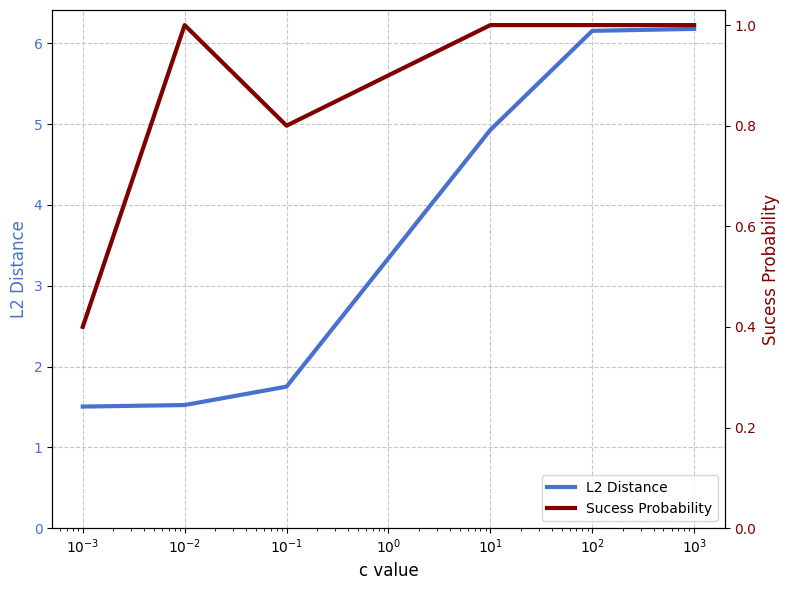

In [25]:
fig, ax1, ax2 = xlab.utils.plot_dual_2d(
    x=list(c_values_to_l2_sum.keys()), 
    y1=list(c_values_to_l2_sum.values()), 
    y2=list(c_values_to_prob.values()),
    y1_label='L2 Distance',
    y2_label='Sucess Probability',
    x_label='c value',
    y1_axis_label='L2 Distance',
    y2_axis_label='Sucess Probability',
    log_x=True,
)

In [ ]:
c_values_to_prob, 

In [31]:
-torch.log(torch.tensor(0.1))

tensor(2.3026)

In [32]:
itos[1]

'automobile'

In [33]:
model(adv_image)

tensor([[-2.2558, 12.9848,  3.5618,  0.7407, -3.0191, -4.9523, -0.8231, -5.2514,
         -0.3696, -0.5469]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [25]:
adv = adv[0].detach().cpu()
x = x_test[0].detach().cpu()
delta = adv - x

_ = xlab.utils.plot_tensors(
    [delta[0], delta[1], delta[2], x.cpu()[0], x.cpu()[1], x.cpu()[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["out delta (red)", "out delta (green)", "out delta (blue)", "image (red)", "image (green)", "image (blue)"]
)

NameError: name 'adv' is not defined

In [300]:
torch.argmax(model(adv))

RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.050887734..1.0007143].


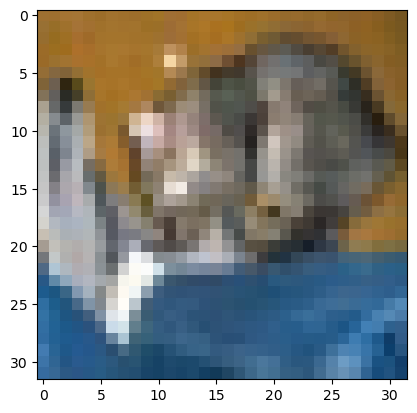

In [283]:
plt.imshow(adv[0].detach().cpu().permute(1,2,0))

In [ ]:
F.cross_entropy(torch.tensor([1.0, 2, 3]), torch.tensor(1))

In [135]:
torch.log(F.softmax(torch.tensor([1.0, 2, 3]), dim=0))

tensor([-2.4076, -1.4076, -0.4076])

$$
f_1(x_{\mathrm{adversarial}}) = -C(F(x_{\mathrm{adversarial}})) + 1
$$

In [2]:
model = load_model(model_name='Standard', threat_model='Linf')
model = model.to('mps')
_ = model.eval()

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 36,479,194


In [4]:
NUM_EXAMPLES = 100
x_test, y_test = load_cifar10(n_examples=NUM_EXAMPLES)
x_test, y_test = x_test.to(device), y_test.to(device)
print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=torch.Size([100, 3, 32, 32]), y_test.shape=torch.Size([100])


In [152]:
def f_6(logits, target, k=0):
    i_neq_t = torch.argmax(logits)
    if i_neq_t == target:
        i_neq_t = torch.argmax(torch.cat([logits[:target], logits[target+1:]]))
    print("in f6", (logits[i_neq_t] - logits[target]).item())
    return torch.max(logits[i_neq_t] - logits[target], -torch.tensor(k))
            

def CW_targeted_l2(img, model, c, target, k=1):
    
    cw_weights = torch.randn_like(img).to('mps') * 0.001
    cw_weights.requires_grad = True
    optimizer = optim.Adam([cw_weights], lr=5e-2)

    num_iters = 100
    delta = 0.5 * (F.tanh(cw_weights) + 1) - img

    k = 0.1

    for i in range(num_iters):
        
        logits = model((img + delta).unsqueeze(0))

        if torch.argmax(logits[0]) == target and torch.sum((delta)**2) <= 0.5:
            return delta

        # print(f_6(logits[0], target))
        assert f_6(logits[0], target, k) >= -k
        success_loss = c * f_6(logits[0], target, k)
        l2_reg = torch.sum((delta)**2)

        loss = success_loss + l2_reg
        print(loss, success_loss, l2_reg)
        
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        delta = 0.5 * (F.tanh(cw_weights) + 1) - img
    print("warning! targeted attack was not successful")
    return delta

In [153]:
torch.max(torch.tensor(5), torch.tensor(-2))

tensor(5)

In [154]:
x = x_test[0]

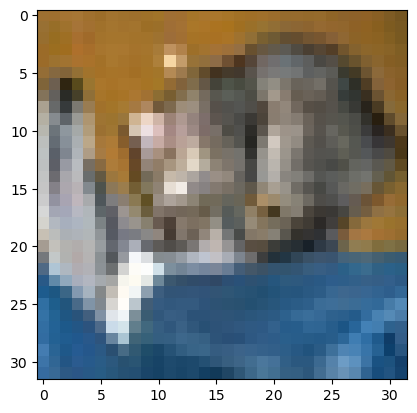

In [155]:
plt.imshow(x.permute(1,2,0).cpu())

In [156]:
out_delta = CW_targeted_l2(x.to('mps'), model, 0.01, 1)

in f6 7.889273643493652
in f6 7.889273643493652
tensor(120.1354, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0789, device='mps:0', grad_fn=<MulBackward0>) tensor(120.0565, device='mps:0', grad_fn=<SumBackward0>)
in f6 8.08248233795166
in f6 8.08248233795166
tensor(97.0092, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0808, device='mps:0', grad_fn=<MulBackward0>) tensor(96.9284, device='mps:0', grad_fn=<SumBackward0>)
in f6 14.96743392944336
in f6 14.96743392944336
tensor(77.6946, device='mps:0', grad_fn=<AddBackward0>) tensor(0.1497, device='mps:0', grad_fn=<MulBackward0>) tensor(77.5449, device='mps:0', grad_fn=<SumBackward0>)
in f6 4.813962936401367
in f6 4.813962936401367
tensor(61.6276, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0481, device='mps:0', grad_fn=<MulBackward0>) tensor(61.5795, device='mps:0', grad_fn=<SumBackward0>)
in f6 1.4890851974487305
in f6 1.4890851974487305
tensor(48.6323, device='mps:0', grad_fn=<AddBackward0>) tensor(0.0149, device='mps:0', gra

In [157]:
out_delta.shape

torch.Size([3, 32, 32])

In [158]:
8/255

0.03137254901960784

In [159]:
out_delta.min(), out_delta.max()

(tensor(-0.0629, device='mps:0', grad_fn=<MinBackward1>),
 tensor(0.0464, device='mps:0', grad_fn=<MaxBackward1>))

In [160]:
max_diff = torch.max(torch.abs(out_delta))

In [161]:
max_diff

tensor(0.0629, device='mps:0', grad_fn=<MaxBackward1>)

In [119]:
assert max_diff < 8/255

Now let's plot what we have. You should 

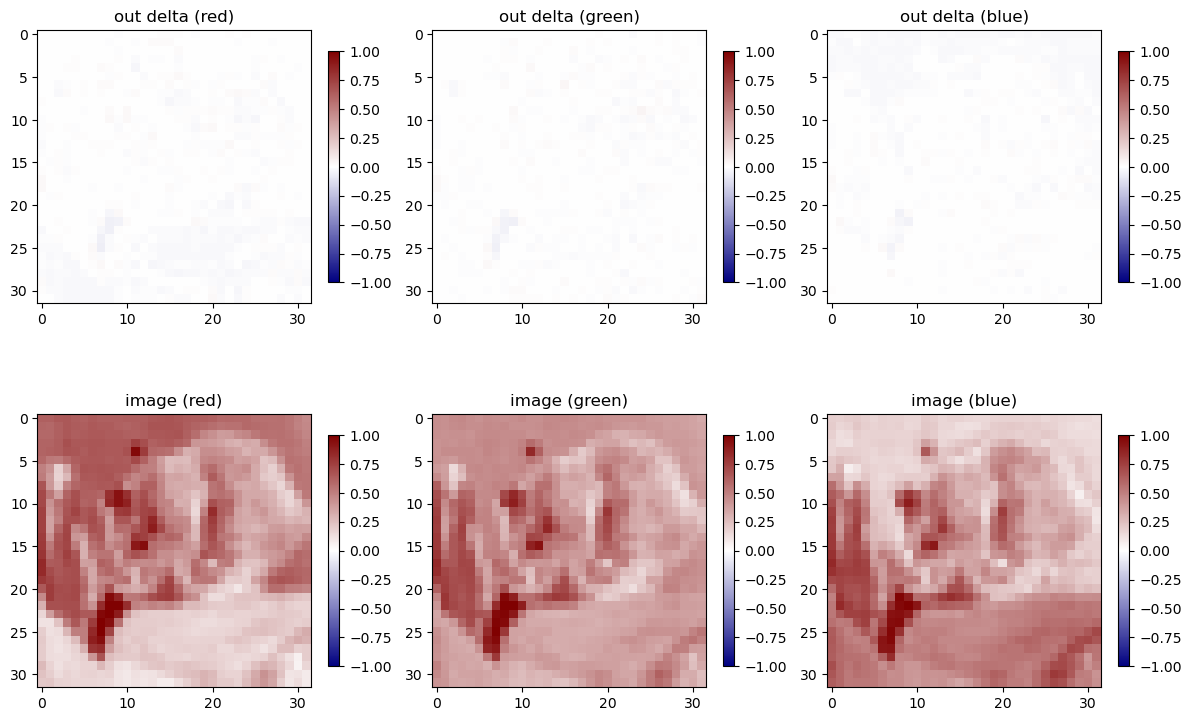

In [162]:
out_delta = out_delta.detach().cpu()

_ = xlab.utils.plot_tensors(
    [out_delta[0], out_delta[1], out_delta[2], x.cpu()[0], x.cpu()[1], x.cpu()[2]],
    log_scale=False, 
    ncols=3,
    # log_scale=True,
    titles = ["out delta (red)", "out delta (green)", "out delta (blue)", "image (red)", "image (green)", "image (blue)"]
)

In [43]:
x_adv = out_delta + x

In [44]:
model(x_adv.unsqueeze(0))

tensor([[13.4251, -0.7176, -1.3678,  3.0889, -5.2713, -1.6484, -1.6464, -2.5078,
         -1.8055, -1.4932]], device='mps:0', grad_fn=<LinearBackward0>)

In [45]:
x_adv.shape

torch.Size([3, 32, 32])

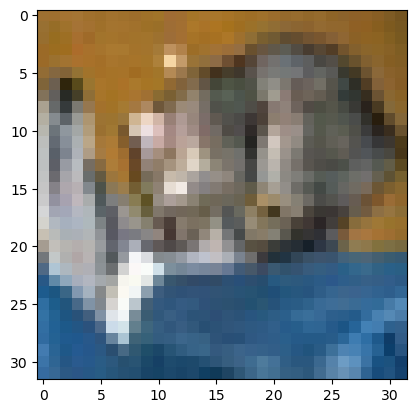

In [46]:
plt.imshow(x_adv.detach().permute(1,2,0).cpu())

## Choosing a constant $c$


<blockquote>
    Empirically, we have found that often the best way to choose
$c$ is to use the smallest value of $c$ for which the resulting
solution $x^{*}$ has $f(x^{*}
)\leq 0$. This causes gradient descent to
minimize both of the terms simultaneously instead of picking
only one to optimize over first.
</blockquote>



On choosing a good $f$:

<blockquote>
The choice of method
for handling box constraints does not impact the quality of
results as significantly for the best minimization functions.
</blockquote>